In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import matplotlib.ticker as ticker
import statsmodels.api as sm
import matplotlib.ticker as mtick

### 下載回測需要的資料 Symbol 是股票代碼 Close 是股票（調整後）收盤價

In [2]:
Row_data = pd.read_csv(f'clean_backtest_data.csv')
data_use = Row_data.copy()
data_use['mdate'] = pd.to_datetime(data_use['mdate'])
data_use = data_use.rename(columns={
    'mdate': 'Date',
    'ROI': 'Ret',
    'coid': 'Symbol',
    'Close': 'ori_Close'
})

data_use['Close'] = data_use['ori_Close'] * data_use['Adjust_Factor']
data_use['Symbol'] = data_use['Symbol'].astype(str)
data_use = data_use.sort_values('Date')

/var/folders/st/lxg2kchn65x5y9ldzc2d4qgh0000gn/T/ipykernel_78533/314268868.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  Row_data = pd.read_csv(f'clean_backtest_data.csv')


In [9]:
# Backtest 版本 : 2025-05-17
class portfolio():
    def __init__(self, initial_cash):
        self.date = None

        # 起始為空
        self.ticker = []
        self.amount = {}
        self.price = {}

        self.cash = initial_cash 
        self.position_value = 0.0
        self.portfolio_value = self.cash + self.position_value
        self.position_data = {}
        self.leverage = 0.0

        self.adjust_coe = 1
        self.initial_cash = initial_cash
        self.overall_cash = initial_cash

    def get_state(self):
        
        package = {
            'Date': self.date,
            'Ticker': self.ticker,
            'Price': self.price,
            'Amount': self.amount,
            'Cash': self.cash,
            'Position_value': self.position_value,
            'Portfolio_value': self.portfolio_value,
            'Leverage': self.leverage,
            'Position_data': self.position_data,
            'Adjust_Factor' : self.adjust_coe
        }
        return package

    def renew(self, Date, Price):
        self.date = Date
        self.price = Price

        #  ticker 改為由 amount 的 key 動態生成，避免漏掉新股票
        self.ticker = list(self.amount.keys())

        self.position_value = sum(self.price.get(i, 0) * self.amount.get(i, 0) for i in self.ticker)
        self.portfolio_value = self.cash + self.position_value

        self.leverage = (self.position_value / self.portfolio_value if self.portfolio_value != 0 else 0)
        self.position_data = {key: (self.price.get(key, 0) * self.amount.get(key, 0)) / self.portfolio_value if self.portfolio_value != 0 else 0 for key in self.ticker}

    def add_cash(self, reinvestment_money):
        self.cash += reinvestment_money
        self.overall_cash += reinvestment_money
        self.adjust_coe = self.overall_cash / self.initial_cash

        self.portfolio_value = self.cash + self.position_value
        self.leverage = (self.position_value / self.portfolio_value if self.portfolio_value != 0 else 0)
        self.position_data = {key: (self.price.get(key, 0) * self.amount.get(key, 0)) / self.portfolio_value if self.portfolio_value != 0 else 0 for key in self.ticker}





class performance():

    def __init__(self):
        # 預先建立空的 DataFrame
        self.df = pd.DataFrame()

    def record(self, portfolio, **kwargs):
        row = copy.deepcopy(portfolio.get_state())
        row.update(kwargs)
        # 把最新一期的 portfolio 資料轉為 df 格式再去 concat 起來
        new_row = pd.DataFrame([row])
        self.df = pd.concat([self.df, new_row], ignore_index=True)

    def add_benchmark(self, symbol, data):
        self.df['Date'] = pd.to_datetime(self.df['Date'])
        benchmark_price_data = data.loc[data['Symbol'] == symbol, ['Date', 'Close']].copy()
        benchmark_price_data = benchmark_price_data.rename(columns = {'Close': 'Benchmark_Close'})
        benchmark_price_data['Date'] = pd.to_datetime(benchmark_price_data['Date'])

        self.df = pd.merge(self.df, benchmark_price_data, on = 'Date', how = 'left')


    def compute_perf(self):
        """缺少 最大回撤"""
        self.df['Strategy_return'] = self.df['Portfolio_value'].pct_change().fillna(0)
        self.df['Strategy_cumulative_return'] = (1 + self.df['Strategy_return']).cumprod() - 1
        self.df['Benchmark_return'] = self.df['Benchmark_Close'].pct_change().fillna(0)
        self.df['Benchmark_cumulative_return'] = (1 + self.df['Benchmark_return']).cumprod() - 1
        self.df['Drawdown'] = (self.df['Portfolio_value'] / self.df['Portfolio_value'].cummax()) - 1
        self.df['Leverage'] = self.df['Position_value'] / self.df['Portfolio_value']

        scale_factor = self.df['Benchmark_return'].std() / self.df['Strategy_return'].std()
        self.df['Vol_match_return'] = self.df['Strategy_return'] * scale_factor
        self.df['Vol_match_cumulative_return'] = (1 + self.df['Vol_match_return']).cumprod() - 1

        self.df['Adjust_portfolio_value'] = self.df['Portfolio_value'] / self.df['Adjust_Factor']
        self.df['Adjust_strategy_return'] = self.df['Adjust_portfolio_value'].pct_change().fillna(0)
        self.df['Adjust_strategy_cumulative_return'] = (1 + self.df['Adjust_strategy_return']).cumprod() - 1

        self.position_df = pd.json_normalize(self.df['Position_data'])
        self.position_df.index = self.df['Date'].dt.strftime('%Y-%m-%d')

    def compute_stat(self, risk_free_rate = 0.0):
        """計算基本統計量：累積報酬率 年化報酬 年化波動度 夏普值 卡碼比率 beta alpha....."""
        
        total_return = (1 + self.df['Strategy_return']).prod() - 1
        annual_return = (1 + total_return) ** (252 / len(self.df['Strategy_return'])) - 1
        annual_volatility = self.df['Strategy_return'].std() * (252 ** 0.5)

        benchmark_return = (1 + self.df['Benchmark_return']).prod() - 1
        benchmark_annual_return = (1 + benchmark_return) ** (252 / len(self.df['Benchmark_return'])) - 1
        benchmark_annual_volatility = self.df['Benchmark_return'].std() * (252 ** 0.5)

        sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility if annual_volatility > 0 else float('nan')
        max_drawdown = self.df['Drawdown'].min()
        calmar_ratio = (annual_return / abs(max_drawdown)) if max_drawdown != 0 else float('nan')

        X = sm.add_constant(self.df['Benchmark_return'])
        model = sm.OLS(self.df['Strategy_return'], X).fit()
        alpha = model.params['const'] * 252  # 年化 alpha
        beta = model.params[self.df['Benchmark_return'].name]

        # 統計結果彙整
        self.stats = {
            '累積報酬率': round(total_return, 4),
            '年化報酬率': round(annual_return, 4),
            '年化波動度': round(annual_volatility, 4),
            '夏普比率': round(sharpe_ratio, 4),
            '最大回撤': round(max_drawdown, 4),
            'Calmar比率': round(calmar_ratio, 4),
            'Alpha (年化)': round(alpha, 4),
            'Beta': round(beta, 4),
            'Benchmark 累積報酬率': round(benchmark_return, 4),
            'Benchmark 年化報酬率': round(benchmark_annual_return, 4),
            'Benchmark 年化波動度': round(benchmark_annual_volatility, 4)
            }
        
        self.stat = pd.DataFrame(self.stats.items(), columns=["指標", "數值"])
        return self.stat

    
    def plot_performance(self):
        """畫出全部的圖片"""
        self.df = self.df.sort_values('Date')
        fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(18, 45), sharex=False)
        fig.suptitle("Backtest Results", fontsize=20, y = 1.0)
        plt.style.use('ggplot')
        axes[0].plot(self.df['Date'], self.df['Strategy_cumulative_return'], label = 'Strategy')
        axes[0].plot(self.df['Date'], self.df['Benchmark_cumulative_return'], label = 'Benchmark')
        axes[0].set_title(f"Strategy Cumulative Return")
        axes[0].legend()
        axes[0].xaxis.set_major_locator(ticker.MaxNLocator(10))

        axes[1].plot(self.df['Date'], self.df['Vol_match_cumulative_return'], label = 'Strategy')
        axes[1].plot(self.df['Date'], self.df['Benchmark_cumulative_return'], label = 'Benchmark')
        axes[1].set_title(f"Strategy Cumulative Return Matched Volatility")
        axes[1].legend()
        axes[1].xaxis.set_major_locator(ticker.MaxNLocator(10))

        axes[2].plot(self.df['Date'], self.df['Adjust_strategy_cumulative_return'], label = 'Strategy')
        axes[2].plot(self.df['Date'], self.df['Benchmark_cumulative_return'], label = 'Benchmark')
        axes[2].set_title(f"Strategy Cumulative Return [Investment Cash Adjusted]")
        axes[2].legend()
        axes[2].xaxis.set_major_locator(ticker.MaxNLocator(10))

        axes[3].plot(self.df['Date'], self.df['Drawdown'])
        axes[3].fill_between(
                    self.df['Date'],
                    self.df['Drawdown'],
                    0,
                    where=(self.df['Drawdown'] < 0),
                    interpolate=True,
                    color='red',
                    alpha=0.3,
                    label='Drawdown Area'
                )
        axes[3].set_title(f'Drawdown Chart')
        axes[3].xaxis.set_major_locator(ticker.MaxNLocator(10))

        axes[4].plot(self.df['Date'], self.df['Leverage'])
        axes[4].yaxis.get_major_formatter().set_useOffset(False)
        axes[4].yaxis.get_major_formatter().set_scientific(False)
        axes[4].set_title(f"Leverage")
        axes[4].xaxis.set_major_locator(ticker.MaxNLocator(10))

        # Position Value
        axes[5].bar(self.df['Date'], self.df['Position_value'], width=1)
        axes[5].set_title('Position Value')
        axes[5].axhline(y=0, linestyle='--', color='g', alpha=0.5)
        axes[5].xaxis.set_major_locator(ticker.MaxNLocator(10))

        # Portfolio Value
        axes[6].bar(self.df['Date'], self.df['Portfolio_value'], width=1)
        axes[6].set_title('Portfolio Value')
        axes[6].axhline(y=0, linestyle='--', color='g', alpha=0.5)
        axes[6].xaxis.set_major_locator(ticker.MaxNLocator(10))

        # Cash Level
        axes[7].bar(self.df['Date'], self.df['Cash'], width=1)
        axes[7].set_title('Cash Level')
        axes[7].axhline(y=0, linestyle='--', color='g', alpha=0.5)
        axes[7].xaxis.set_major_locator(ticker.MaxNLocator(10))

        axes[8].plot(self.df['Date'], self.df['Strategy_return'])
        axes[8].set_title('Period Return')
        axes[8].xaxis.set_major_locator(ticker.MaxNLocator(10))

        for i in self.position_df.columns:
            axes[9].plot(self.position_df.index, self.position_df[i], label = i)
        axes[9].set_title('Position Data')
        axes[9].legend()
        axes[9].xaxis.set_major_locator(ticker.MaxNLocator(10))

        plt.tight_layout()
        plt.show()



class Market:
    def __init__(self):
        self.price_data = {}

    def update_prices_from_df(self, df: pd.DataFrame, date_col: str = 'Date', price_col: str = 'Close', target_date=None):
        """
        根據目標日期，從 DataFrame 擷取當天所有股票的收盤價。
        - df: 包含股票、收盤價、日期的 DataFrame
        - date_col: 日期欄位名稱
        - price_col: 收盤價欄位名稱
        - target_date: 欲擷取的日期
        """

        # 篩選出當天資料
        df_today = df[df[date_col] == target_date]
        

        if df_today.empty:
            print(f"⚠️ {target_date} 無交易資料（可能是非交易日），price_data 未更新")
            return
        

        # 更新價格資料到 price_data 字典中
        self.price_data = dict(zip(df_today['Symbol'], df_today[price_col]))

    def get_price_dict_for_tickers(self, tickers: list):
        """
        從 self.price_data 擷取指定股票代號的價格字典。
        """
        return {ticker: self.price_data.get(ticker, None) for ticker in tickers}

    def get_price(self, symbol):
        return self.price_data.get(symbol, None)



def order(portfolio, symbol, target, Market):
    context = portfolio.get_state()
    position = context['Position_data'].get(symbol, 0.0)

    if abs(position - target) < 0.0005:
        return
    
    now_price = Market.get_price(symbol)

    #  加入價格缺失防呆機制
    if now_price is None or now_price == 0:
        print(f"⚠️ {context.get('Date')}略過下單：{symbol} 在當日沒有價格資料")
        return
    
    target_pos = target - position
    use_money = target_pos * portfolio.portfolio_value

    add_amount = int(use_money / now_price)
    cost = add_amount * now_price
    
    portfolio.amount[symbol] = portfolio.amount.get(symbol, 0.0) + add_amount
    portfolio.cash -= (cost)
    portfolio.position_value += cost
    portfolio.position_data[symbol] = position + target_pos
    portfolio.portfolio_value =  portfolio.cash + portfolio.position_value
    portfolio.leverage = portfolio.position_value / portfolio.portfolio_value 
    if symbol not in portfolio.ticker:
        portfolio.ticker.append(symbol) 

    return



def run_backtest(data, strategy_function, start_date, end_date, Benchmark_code = 'IR0001', factor_data = None, initial_cash = 1_000_000):
    context = portfolio(initial_cash = initial_cash)
    perf = performance()
    mkt = Market()

    data['Symbol'] = data['Symbol'].astype(str)
    data['Date'] = pd.to_datetime(data['Date'])
    #  過濾時間資料
    if start_date is not None:
        if end_date is not None:
            start_date = pd.to_datetime(start_date)
            end_date = pd.to_datetime(end_date)
            data = data[data['Date'] >= start_date].copy()
            data = data[data['Date'] <= end_date].copy()

    data = data.sort_values('Date')
    backtest_dates = sorted(data['Date'].dt.strftime('%Y-%m-%d').unique())

    print(f'--'*25,'Strategy Logic Start','--'*25)

    for idx, date in enumerate(backtest_dates):
        # 更新市場資訊（收盤價格）
        mkt.update_prices_from_df(df=data, target_date=date)
        # ================================= 交易邏輯 開始 ===================================

        strategy_function(idx, date, context, perf, mkt, factor_data)

        # ================================= 交易邏輯 結束 ===================================
        # 更新與紀錄
        new_price = mkt.get_price_dict_for_tickers(tickers=context.ticker)
        context.renew(Date=date, Price=new_price)
        perf.record(portfolio=context)

    print(f'--'*25,'Strategy Logic End','--'*25)

    perf.df = perf.df.sort_values('Date')
    perf.add_benchmark(symbol = Benchmark_code, data = data)
    perf.compute_perf()

    return perf


### 簡易策略邏輯：在回測第一天買入總資金的 40% 的 台積電 2330、20% 的聯電 2303

In [ ]:
# 簡易策略邏輯：在回測第一天買入總資金的 40% 的 台積電 2330、20% 的聯電 2303

def logic(idx, date, portfolio, performance, market, factor_data):
    if idx == 0:
        order(portfolio=portfolio, symbol = '2330', target = 0.4, Market=market)
        order(portfolio=portfolio, symbol = '2303', target = 0.2, Market=market)


result = run_backtest(data = data_use,
                       strategy_function = logic, 
                       start_date = '2020-01-01', 
                       end_date = '2025-01-01', Benchmark_code = 'IR0001',
                       factor_data = None, 
                       initial_cash = 1_000_000)


# 呼叫函數 compute_stat() 計算回測績效數據
result.compute_stat()
    

-------------------------------------------------- Strategy Logic Start --------------------------------------------------
-------------------------------------------------- Strategy Logic End --------------------------------------------------


,指標,數值
0,累積報酬率,1.4889
1,年化報酬率,0.2080
2,年化波動度,0.2121
3,夏普比率,0.9807
4,最大回撤,-0.3306
5,Calmar比率,0.6292
6,Alpha (年化),0.0344
7,Beta,0.9519
8,Benchmark 累積報酬率,1.2557
9,Benchmark 年化報酬率,0.1836


### 畫出整個策略的績效圖表 

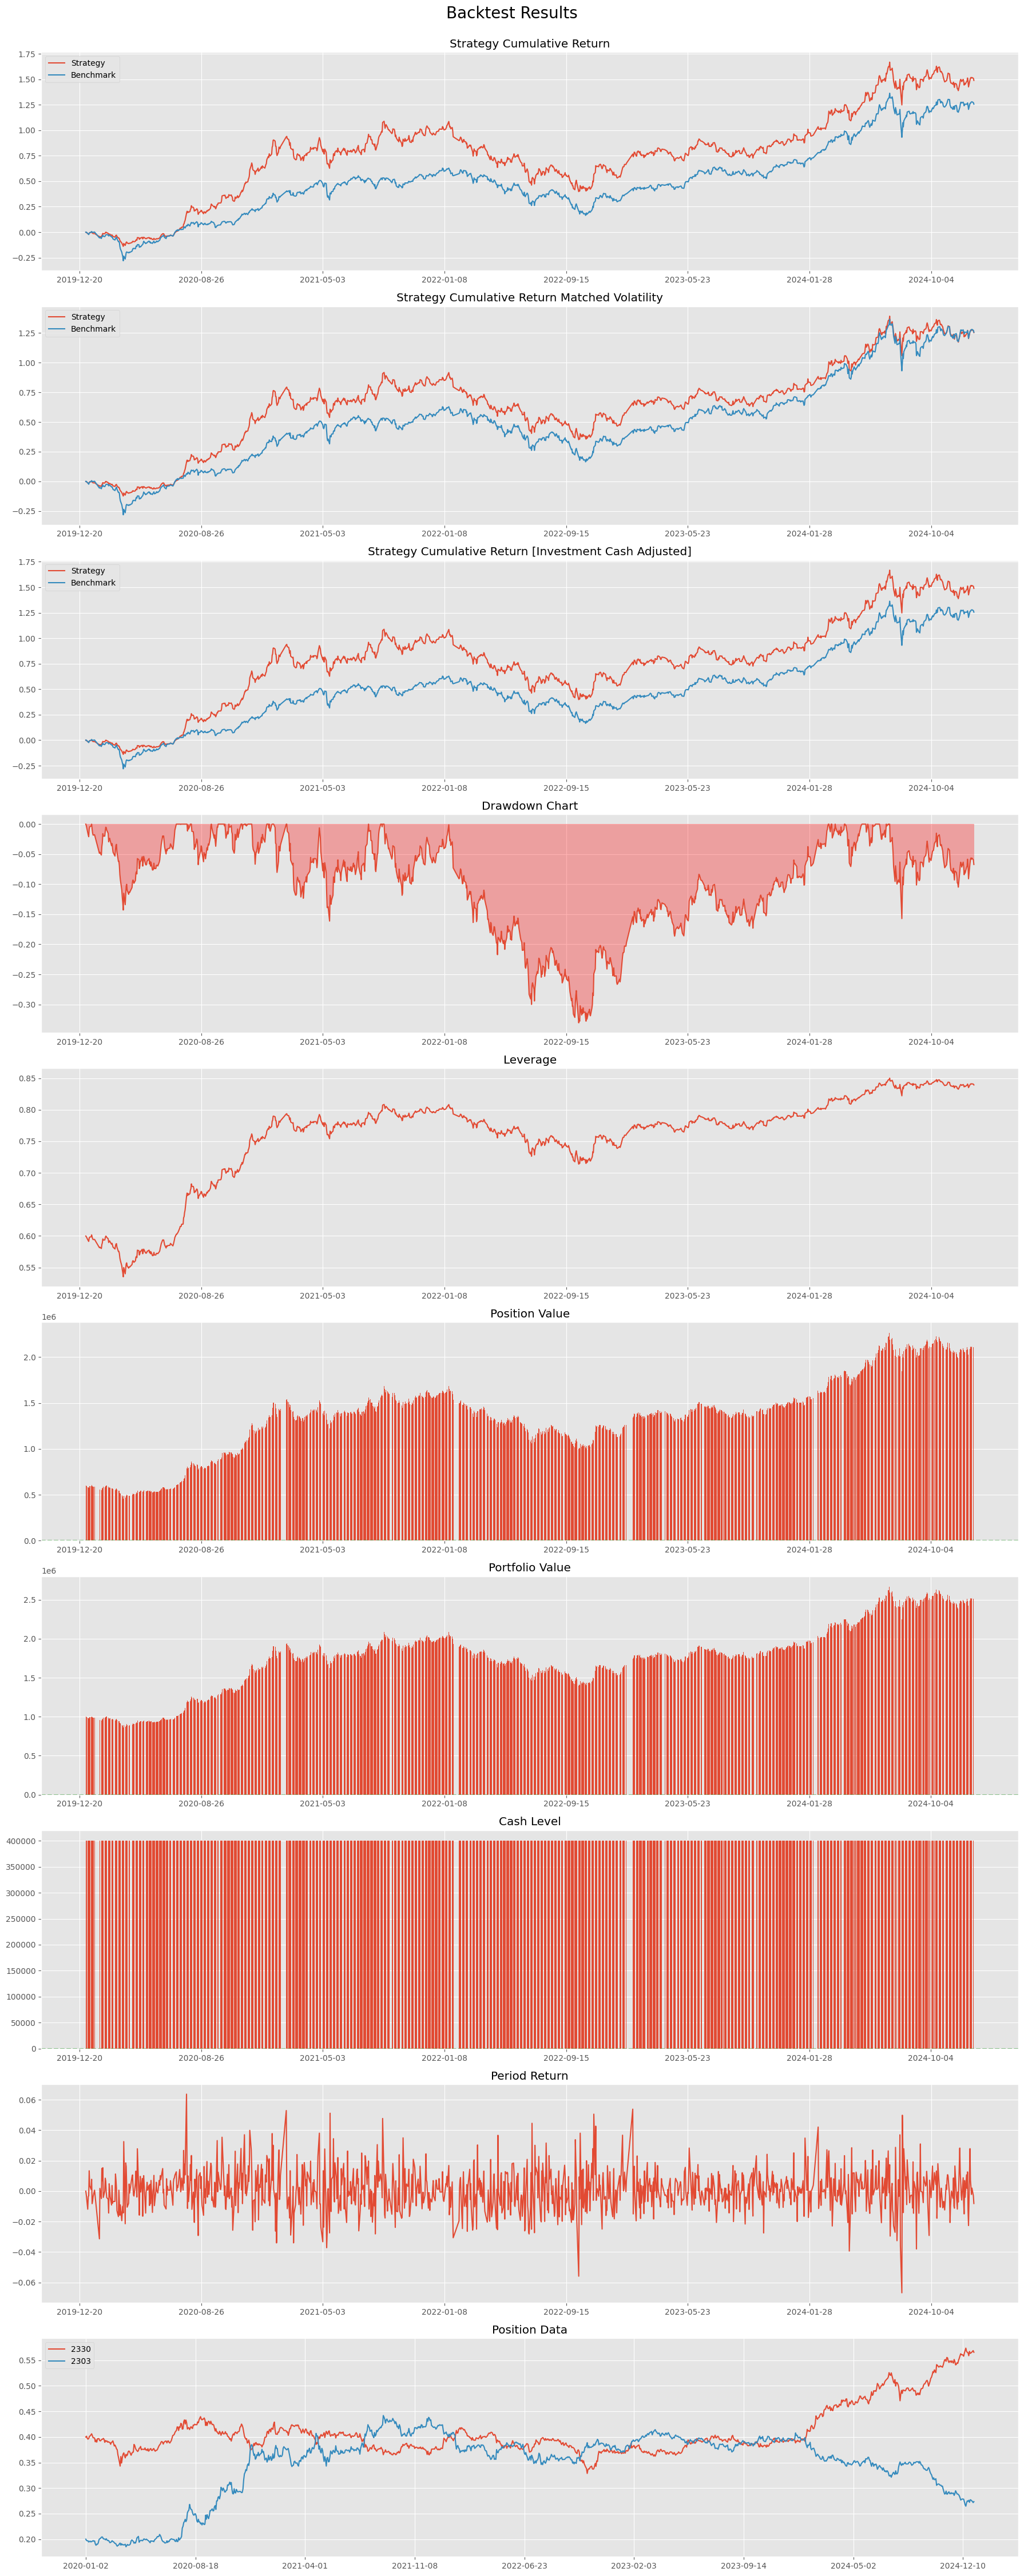

In [12]:
result.plot_performance()